Groupe:

1 - Nom, Prénom, Matricule:

2 - Nom, Prénom, Matricule:

Ce laboratoire a pour objectif de manipuler et analyser la manipulation et le filtrage d'images dans le domaine temporel et fréquentiel.

**Remise**: 

La date de remise est le lundi 2 Novembre à 23h55. Une pénalité de 3 points par jour sera appliquée lors d'un retard.

**Documents à remettre** :


Les exercices doivent être codés dans ce fichier TP.ipynb. Les réponses aux questions doivent être incluses dans le code sous forme de commentaires ou dans des cellules dédiées (*Markdown* ou *text*). Les exercices doivent être séparés par des cellules, suivant le template fourni. Vous devez bien identifier chaque exercice et sous-question, et bien commenter le code. Veuillez nommer vos variables de manière explicite et assurez-vous que toutes les figures soient lisibles.

Créer un fichier de rendu **html** (*Fichier -> Télécharger au format... -> HTML*)  de votre code et de vos graphiques. Veuillez remettre tous vos fichiers (.ipynb, html et autres) dans un seul fichier **zip** et nommez ce fichier selon vos matricules (Mat1\_Mat2.zip).


Une pénalité de 3 points sera appliquée si ces consignes ne sont pas respectées.

# Première séance: Filtrage spatial d'image

**Note:** Lors de la conception de vos algorithmes, portez attention aux types de vos données (*np.uint8*, *np.float32*, etc.). Lors de la manipulation des images, il sera probablement nécessaire de passer en *np.float32* pour faire vos calculs puis de revenir en *np.uint8* pour afficher vos images

**Note 2:** Nous vous suggérons fortement d'utiliser la fonction imshow de la manière suivante:
    
```python
    plt.imshow(mon_img, vmin=0, vmax=255)
    # ou bien
    ax.imshow(mon_img, vmin=0, vmax=255)
```
Cela précise à matlplolib que toutes les valeurs de l'image inférieures ou égales à zéros doivent être affichées en noires et celles supérieures ou égales à 255 en blancs (ce qui l'intervalle standard d'image codée en uint8). Si vous travaillez avec des images dont les valeurs sont comprises entre 0 et 1, vous aurez à modifier l'intervalle en conséquences.

In [1]:
import cv2
import bisect
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray' # Choix de la color map par défaut, ne pas modifier
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0) # Taille des figures par défaut, peut-être modifié au cas par cas.

## Exercice 1 - Réhaussement d'image
Le but de cet exercice est de corriger les effets d'une image fortement altérée. Pour cela, vous allez implémenter un certain nombre de filtres basiques pour corriger les différents défauts.

### Question 1 (1.5 points)
Chargez l'image *TempsModernes.jpeg* en utilisant la fonction:
```python
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
```
(a) Affichez l'image. Comme vous pouvez le constater, l'image est très sombre et peu contrastée. Affichez à côté de l'image son histogramme en utilisant la fonction fournie dans la cellule ci-dessous. 

(b) Nous allons corriger son exposition et son contraste en implémentant l'égalisation d'histogramme telle que vue en cours.
Complétez le code suivant:
```python
def equalize_histogram(img):
    imegale = np.zeros(img.shape)
    hist, bins = np.histogram(img, 256,[0,256])
    hist = hist.astype(np.float32)
    ...
```
Affichez l'image égalisée et son histogramme. Que constatez-vous?

In [2]:
def plot_histogram(img, ax=None):
    """
    param img: image au format np.ndarray, dont les valeurs sont comprises entre 0 et 255
    param ax: (optionnel) axe matplotlib sur lequel tracer l'histogramme. 
    """
    hist, bins = np.histogram(img, 256,[0,256])
    if ax is not None:
        ax.bar(bins[:-1], hist)
    else:
        plt.bar(bins[:-1], hist)
        plt.show()

In [3]:
def equalize_histogram(img):
    imegale = np.zeros(img.shape)
    hist, bins = np.histogram(img, 256,[0,256])
    hist = hist.astype(np.float32)
    
    hist_normalized = hist / img.size
    hist_normalized_cum = hist_normalized.cumsum()
    
    #générer l'image finale
    imegale = 255 * hist_normalized_cum[img]
    return imegale
    

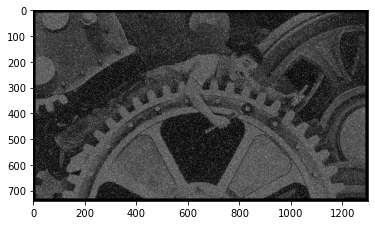

In [4]:
# Chargement et affichage de l'image
img = cv2.imread("TempsModernes.jpeg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, vmin=0, vmax=255)

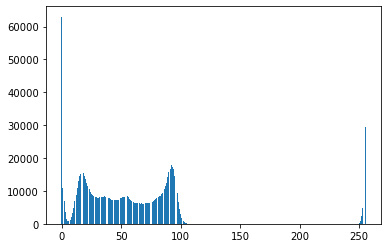

In [5]:
plot_histogram(img)

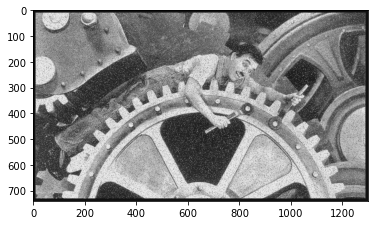

In [6]:
image_contraste_corriger = equalize_histogram(img)
plt.imshow(image_contraste_corriger, vmin=0, vmax=255)

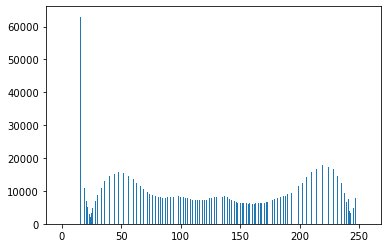

In [7]:
plot_histogram(image_contraste_corriger)

### Question 2 (1 point)
Quel type de bruit est semble particulièrement prédominant dans l'image égalisée? Expliquez pourquoi un filtre médian est adapté pour le corriger. Vérifiez que c'est bien le cas en filtrant l'image avec un filtre de taille 5.


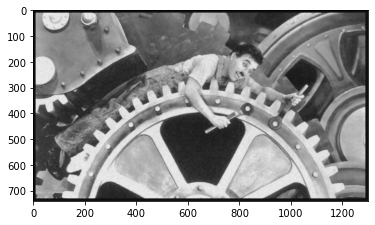

In [8]:
image_float32 = image_contraste_corriger.astype('float32')
image_floutee = cv2.medianBlur(image_float32, 5).astype('uint8')
plt.imshow(image_floutee, vmin=0, vmax=255)


### Question 3 (1,5 points)
Pour la suite, vous allez avoir besoin d'utiliser le filtrage par convolution 2D. Implémentez la fonction conv2d qui prend en arguments une image et un masque et sort la convolution des deux. Vous n'utiliserez que les opérations matricielles et au maximum 2 boucles for, en particulier l'utilisation de toute fonction de convolution pré-existante est interdite. Pour que la taille de l'image convoluée soit la même que l'image de départ, vous effectuerez un *0 padding*. Pour cela, vous pouvez vous inspirer du code suivant (à compléter). On supposera que le masque est toujours carré et sa taille toujours impaire.
```python

def conv2d(img, mask):
    out = np.zeros(img.shape, dtype=np.float32)
    size_mask = mask.shape[0]
    pad_values = ...
    img = np.pad(img, ((pad_values, pad_values), (pad_values, pad_values)))
    for i, row in enumerate(out):
        for j, col in enumerate(row):
            out[i, j] = ...
    return out

```
Testez votre implémentation en filtrant votre image médiane avec le masque gaussien suivant:
```python
mask = np.asarray([[1,2,1,2,1],[2,4,8,4,2],[1,8,18,8,1],[2,4,8,4,2],[1,2,1,2,1]])/90
```
et affichez le résultat. Qu'observez-vous?

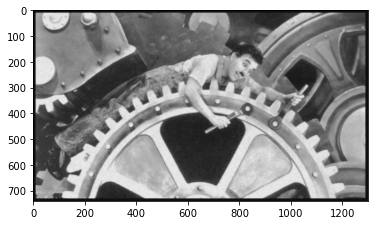

In [9]:
def conv2d(img, mask):
    out = np.zeros(img.shape, dtype=np.float32)
    size_mask = mask.shape[0]
    pad_values = size_mask // 2
    img = np.pad(img, ((pad_values, pad_values), (pad_values, pad_values)))
    for i, row in enumerate(out):
        for j, col in enumerate(row):
            sub_arr = img[i: (i + size_mask), j : (j + size_mask)]            
            prod = np.multiply(sub_arr, mask)
            out[i,j] = np.sum(prod)
    return out


mask = np.asarray([[1,2,1,2,1],[2,4,8,4,2],[1,8,18,8,1],[2,4,8,4,2],[1,2,1,2,1]])/90
gauss = conv2d(image_floutee, mask)
plt.imshow(gauss.astype('uint8'), vmin=0, vmax=255)

### Question 4 (1 point)
Nous allons rectifier l'effet du filtre gaussien précédent en implémentant un filtre réhausseur de contours. Pour cela, nous ferons appel au Laplacien de l'image que l'on note:
$\Delta(I)$. 
Implémentez un filtre réhausseur de contours fonctionnant en deux étapes:
1. Un filtre passe-bas gaussien est appliqué: $I_g = G * I$
2. $I_r = I_g + k\times \Delta(I_g)$ 
où $k$ est une constante que vous ferez varier pour obtenir le meilleur résultat.
On rappelle que le Laplacien peut s'obtenir avec une convolution avec un masque:
```python
masque_laplacien = np.asarray([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
```
Pour le filtre Gaussien, utilisez le filtre:
```python
masque_gaussien = np.asarray([[1,2,1], [2,4,2], [1,2,1]])
```


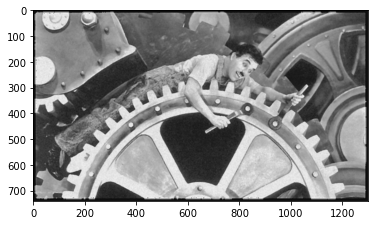

In [10]:
masque_laplacien = np.asarray([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])

masque_gaussien = np.asarray([[1,2,1], [2,4,2], [1,2,1]])
masque_gaussien = masque_gaussien / np.sum(masque_gaussien)
I_g = conv2d(gauss, masque_gaussien)
k = 0.6
I_r = I_g + k * conv2d(I_g, masque_laplacien)
plt.imshow(I_r.astype('uint8'), vmin=0, vmax=255)

## Exercice 2 - Compteur de pièces de monnaie

On vous a confié la tâche de réaliser un compteur de monnaie. Puisque la monnaie canadienne est essentiellement ronde, voilà l'occasion parfaite pour utiliser vos connaissances en filtrage morphologique.

**Note**: Il existe un excellent [tutoriel](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html) sur l'utilisation du filtrage morphologique avec open-cv dont nous vous recommendons fortement la lecture.

### Question 1 (0,5 point)
Chargez l'image **pieces.jpg** et convertissez la en niveau de gris. Affichez cette image.


[[254 254 253 ... 254 254 254]
 [254 254 253 ... 254 254 254]
 [254 253 253 ... 254 254 254]
 ...
 [253 253 253 ... 253 253 253]
 [253 253 253 ... 252 252 252]
 [253 253 253 ... 252 252 252]]


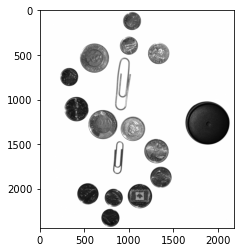

In [11]:
img = cv2.imread("pieces.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, vmin=0, vmax=255)
print(img)

### Question 2 (0,5 point)
Implémentez la fonction 
```python
def binariser(img, seuil):
    ...
```
qui met à 0 tous les pixels se trouvant en dessous du seuil, et à 255 tous les pixels se trouvant sur le seuil ou au dessus. Cette fonction prend en arguments une image et un seuil, puis retourne l'image binaire. Binarisez votre image avec un seuil égal à 250. Bien sûr, puisque nous voulons que ce soit les pièces qui soient blanches, vous devez inverser la couleur. Affichez l'image binaire.


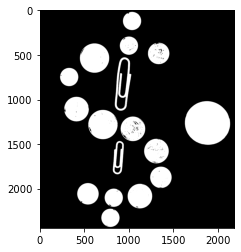

In [12]:
def binariser(img, seuil):
    out = np.zeros(img.shape, dtype=np.float32)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if (img[x][y] < seuil):
                out[x][y] = 255
            else:
                out[x][y] = 0
    return out

binarized = binariser(img, 250)
plt.imshow(binarized, vmin=0, vmax=255)
    

### Question 3 (1 point)
Vos pièces ne sont pas totalement pleines. Effectuez une fermeture sur l'image binaire afin de fermer les trous, tout en ne changeant pas trop la taille des pièces. Vous devez choisir un bon élément structurant. Affichez le résultat.

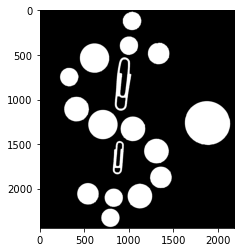

In [13]:
kernel = np.ones((23,23),np.uint8)
closed = cv2.morphologyEx(binarized, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, vmin=0, vmax=255)

### Question 4 (3 points)
Implémentez la fonction:
```python
def compter_monnaie(img_bin):
    ...
```
 qui compte le total de la monnaie de votre image binaire à l'aide des opérateurs morphologiques imerode ou imdilate. La sortie de la fonction doit être exprimée en dollars. 
Voici des rayons de disques qui pourront vous être utiles : 200, 140, 120, 110, 90 (on ignorera les pièces de 1 dollar, 50 et 1 cent qui sont absentes de l'image). 

Vous pouvez utiliser la fonction suivante pour compter le nombre de composantes connectées dans l'image.
```python
def nb_components(img_bin):
    num_labels, labels_im = cv2.connectedComponents(img_bin)
    return num_labels-1 # On retire le fond qui est componente connectée mais qui ne nous intéresse pas
```

[0, 0.1, 0.1, 0.05, 2, 0.1, 0.25, 0, 2, 0.25, 0.25, 0.05, 0.05, 0.25, 0.1, 0.1]


5.6499999999999995

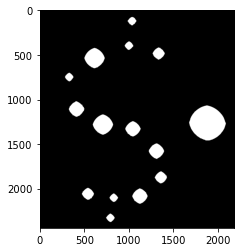

In [56]:
def monnaie(rayon, breakpoints=[90, 110, 120, 140, 200], valeur=[0, 0.1, 0.05, 0.25, 2, 0]):
    i = bisect.bisect(breakpoints, rayon)
    return valeur[i]

def compter_monnaie(img_bin):
    kernel = np.ones((45,45),np.uint8)

    erosion = cv2.erode(img_bin ,kernel, iterations = 2)
    ouverture = cv2.dilate(erosion ,kernel, iterations = 2) #on fait une ouverture pour éliminer les trombones par l'érosion
    
    plt.imshow(erosion, vmin=0, vmax=255)

    num_labels, labels_im = cv2.connectedComponents(ouverture)

    components_areas = np.zeros(num_labels)

    for x in range(labels_im.shape[0]):
        for y in range(labels_im.shape[1]):
            if (labels_im[x][y] != 0):
                components_areas[labels_im[x][y]] = components_areas[labels_im[x][y]] + 1
                
    rayons =  np.sqrt(components_areas / np.pi)
    
    res = [monnaie(rayon) for rayon in rayons]
    print(res)
    return np.sum(res)

compter_monnaie(closed.astype('uint8'))



# Séance 2: Transformée de Fourier et Filtrage spectral
## Exercice 3 Transformée de Fourier 2D
Cet exercice vise à vous familiariser avec le calcul de la transformée de Fourier en deux-dimensions et certaines de ses propriétés.

Pour cela, nous allons étudier la fonction:
$f(x, y) = \sin(\frac{2\pi}{256}[f_1 x+f_2 y] ) \text{  avec  } x, y \in [0, 256]$

### Question 1 (1 point)
Créez la fonction:
```python
def f(f1, f2):
    ...
```
qui prend en arguments les différentes constantes $\{f_1, f_2\}$ et renvoie une image monochrome de dimensions 256x256. Nous vous suggérons très fortement de vous référer à la documention de la fonction [np.meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) pour une implémentation efficace (sans boucle for).

### Question 2 (1,5 points)
Pour chaque jeux de paramètres suivants, affichez sur deux plots adjacents l'image de $f(x,y)$ et son spectre (amplitude de sa transformée de Fourier). 

$\{f_1, f_2\}=$
1. \{12, 0\}
2. \{0, 12\}
2. \{12, 12\}
1. \{12, 32\}
1. \{32, -32\}

Nous vous imposons de créer une fonction:
```python
def fft_spectre(img):
    ...
```
qui prend en argument une image et renvoie le spectre de sa transformée de Fourier normalisée de telle sorte que sa valeur maximale soit égale à 1 et sa valeur minimale à 0. Utilisez les fonctions [np.fft.fft2](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html#numpy.fft.fft2) et [np.fft.fftshift](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html#numpy.fft.fftshift).
Pour la normalisation, vous pouvez utiliser la relation:
$f_{normalisée} = \frac{f-\min(f)}{\max(f)-\min(f)}$
**Note:** N'oubliez pas de donner un titre à vos graphiques permettant de bien les identifier!

### Question 3 (1 point)
Complétez les phrases suivantes, en vous basant sur vos observations à la question précédente sur les propriétés de la transformée de Fourier.

In [ ]:
prop = "L'homothétie (agrandissement ou réduction) d'une image selon un axe donné \
entraîne %s sur son spectre dans le domaine de Fourier."
ans = "..." 
print(prop%ans)


prop = "La rotation d'angle alpha d'une image \
entraîne %s sur son spectre dans le domaine de Fourier."
ans = "..."
print(prop%ans)

### Question 4 (1 point)
Soit la fonction:

$f(x, y)=\sin(\frac{2\pi}{256}f_1r)$ où $r=\sqrt{x^2+y^2} \text{  avec  } x, y \in [-128, 128]$

Créez la fonction:
```python
def wave(f1):
    ...
```
qui prend en arguments la constante $f_1$ et renvoie une image monochrome de dimensions 256x256.

Comme précédemment, tracez sur une figure le couple image/spectre pour les valeurs de $f_1$ suivantes:
$f_1=\{12,64,128,256\}$
Que remarquez-vous?

## Exercice 4  Filtrage Spectral et homomorphique

### Question 1 (1 point)
Un fichier mystère vous est fourni, représentant une célèbre image. Malheureusement, son identification est rendue impossible, du fait d'un double signal sinusoidal parasite, de fréquence $\pm 75$ selon chaque direction ($\pm x, \pm y$).



Chargez le fichier intitulé **imageMystere.png**, affichez-là ainsi que sa transformée de Fourier.

**Note:** Jusqu'à présent, nous avions étudié des images artificielles avec un contenu fréquentiel volontairement léger. Le spectre de l'image mystère est beaucoup plus dense, par conséquent sa visualisation est rendue légèrement plus complexe (les nombreuses fréquences présentes ont chacune des amplitudes très petites). Pour mieux voir ce qui se passe, affichez le spectre en décibel:
```python
epsilon = 1e-7 # Pour éviter de prendre le logarithme de zéro
plt.imshow(20*np.log10(spectre+epsilon))
plt.show()
```
Sachant que le centre du spectre (après fftshift) correspond aux fréquences (0,0), vérifiez que vous retrouvez la trace des signaux pertubatoires sur le spectre de la fft.

### Question 2 (2 points)

Nous allons effacer les perturbations directement depuis le domaine spectrale, en créant un filtre qui sera directement appliqué (par multiplication) à la fft.
Le filtre sera concu suivant un (ou plusieurs) profil(s) Gaussien selon la formule:

$H(u, v) = 1-e^{-((u \pm f)^2+(v \pm f)^2)/\sigma }$ où $\sigma$ permettra de contrôler la sélectivité du filtre et $f$ les fréquences à filtrer.

Adaptez cette formule pour créer un masque permettant de filtrer les perturbations et affichez ce masque. On choisira $\sigma=5$. Quel type de filtre (passe-bas, passe-haut, ...) reconnaissez-vous? Visuellement, que contrôle le paramètre $\sigma$ ?

### Question 3 (1 point)

Utilisez votre masque pour filtrer la transformée de Fourier (attention, pas juste le module!) et reconstruisez l'image par transformée de Fourier inverse [np.fft.ifft2](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.fft.ifft2.html).
Affichez l'image reconstruite ainsi que sa transformée de Fourier

### Question 4 (1,5 points)
On rappelle la définition du filtrage homomorphique:
$H(u, v)=(\gamma_H-\gamma_L)[1-e^{-c\frac{D^2(u, v)}{D^2_0}}]+\gamma_L$ où $D(u, v)=u^2+v^2$

Implémentez ce filtre et testez-le avec les paramètres suivants:
$D_0=2, \gamma_H=2, \gamma_L=0.5, c=1$.
N'oubliez pas que ce filtre s'applique sur la transformée de Fourier de l'image **logarithmique**. Une fois le filtre appliqué et de retour dans le domaine spatial, il faudra donc prendre l'**exponentielle** du résultat.


Affichez le résultat (filtre et image filtrée) et décrivez l'effet des paramètres $\gamma_H, \gamma_L$ et $D_0$.